## Import Libraries

In [1]:
#! pip install yfinance
#! pip install ydata-profiling
#!pip3 install numpy==1.22

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from ydata_profiling import ProfileReport

## Data Scrapping

In [3]:
# Define the stock symbol and the time range
symbol = "DJI"
start_date = "2000-01-01"
end_date = "2023-01-01"

In [4]:
# Fetch historical stock data
data = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [5]:
data.head(10)

Open          High           Low         Close  \
Date                                                                 
2000-01-03  11357.500000  11357.500000  11357.500000  11357.500000   
2000-01-04  10997.900391  10997.900391  10997.900391  10997.900391   
2000-01-05  11122.700195  11122.700195  11122.700195  11122.700195   
2000-01-06  11253.299805  11253.299805  11253.299805  11253.299805   
2000-01-07  11522.599609  11522.599609  11522.599609  11522.599609   
2000-01-10  11572.200195  11572.200195  11572.200195  11572.200195   
2000-01-11  11511.099609  11511.099609  11511.099609  11511.099609   
2000-01-12  11551.099609  11551.099609  11551.099609  11551.099609   
2000-01-13  11582.400391  11582.400391  11582.400391  11582.400391   
2000-01-14  11723.000000  11723.000000  11723.000000  11723.000000   

               Adj Close  Volume  
Date                              
2000-01-03  11357.500000       0  
2000-01-04  10997.900391       0  
2000-01-05  11122.700195       0  
2000-01-06  11253.299805       0  
2000-01-07  11522.599609       0  
2000-01-10  11572.200195       0  
2000-01-11  11511.099609       0  
2000-01-12  11551.099609       0  
2000-01-13  11582.400391       0  
2000-01-14  11723.000000       0

In [6]:
total_rows = data.shape[0]
data.shape

(5405, 6)

In [7]:
data.describe()

Open          High           Low         Close     Adj Close  \
count   5405.000000   5405.000000   5405.000000   5405.000000   5405.000000   
mean   15301.326939  15305.156246  15296.961629  15301.223146  15301.223146   
std     6904.788584   6910.094014   6898.799658   6904.610201   6904.610201   
min     6547.049805   6547.049805   6547.049805   6547.049805   6547.049805   
25%    10470.700195  10470.700195  10470.700195  10470.700195  10470.700195   
50%    12447.500000  12447.500000  12447.500000  12447.500000  12447.500000   
75%    17912.599609  17912.599609  17912.599609  17912.599609  17912.599609   
max    36799.699219  36799.699219  36799.699219  36799.699219  36799.699219   

             Volume  
count  5.405000e+03  
mean   3.866542e+07  
std    9.073078e+07  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    0.000000e+00  
max    7.582325e+08

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5405 entries, 2000-01-03 to 2022-03-02
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5405 non-null   float64
 1   High       5405 non-null   float64
 2   Low        5405 non-null   float64
 3   Close      5405 non-null   float64
 4   Adj Close  5405 non-null   float64
 5   Volume     5405 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 295.6 KB


###  Feature Addition - Relative Strength Index (RSI)

In [9]:
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)

    ma_up = up.rolling(window=window).mean()
    ma_down = down.rolling(window=window).mean()

    rsi = 100 - (100 / (1 + ma_up / ma_down))
    return rsi

data['RSI'] = calculate_rsi(data)

In [10]:
overbought_threshold = 70
oversold_threshold = 30

# A stock is labeled '1' if it's overbought or oversold, '0' otherwise
data['Target'] = ((data['RSI'] > overbought_threshold) | (data['RSI'] < oversold_threshold)).astype(int)


In [11]:
data.head()

Open          High           Low         Close  \
Date                                                                 
2000-01-03  11357.500000  11357.500000  11357.500000  11357.500000   
2000-01-04  10997.900391  10997.900391  10997.900391  10997.900391   
2000-01-05  11122.700195  11122.700195  11122.700195  11122.700195   
2000-01-06  11253.299805  11253.299805  11253.299805  11253.299805   
2000-01-07  11522.599609  11522.599609  11522.599609  11522.599609   

               Adj Close  Volume  RSI  Target  
Date                                           
2000-01-03  11357.500000       0  NaN       0  
2000-01-04  10997.900391       0  NaN       0  
2000-01-05  11122.700195       0  NaN       0  
2000-01-06  11253.299805       0  NaN       0  
2000-01-07  11522.599609       0  NaN       0

## Data Cleaning

### Handling null values

In [12]:
data.isna().sum()

Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
RSI          14
Target        0
dtype: int64

In [13]:
data.dropna(inplace=True)

In [14]:
current_rows = data.shape[0]
print("Data availabe after dropping null values(%):",current_rows/total_rows*100)

Data availabe after dropping null values(%): 99.74098057354301


# Data visualization

In [39]:
report = ProfileReport(data)
report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

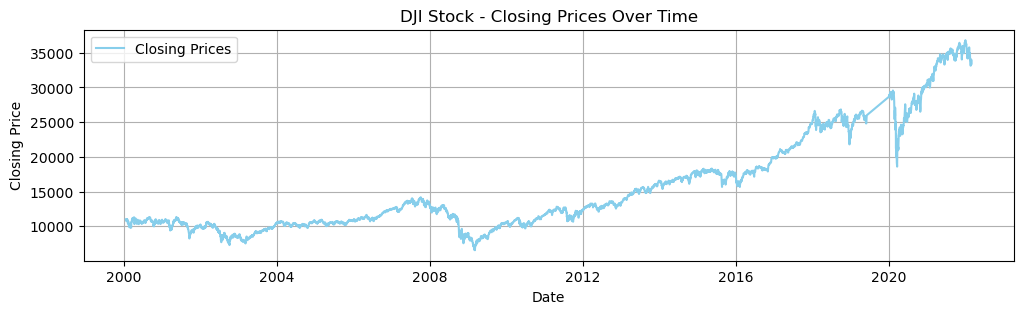

In [17]:
# Line plot of closing prices
plt.figure(figsize=(12, 3))
plt.plot(data['Close'], label='Closing Prices', color='skyblue')
plt.title(f'{symbol} Stock - Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()


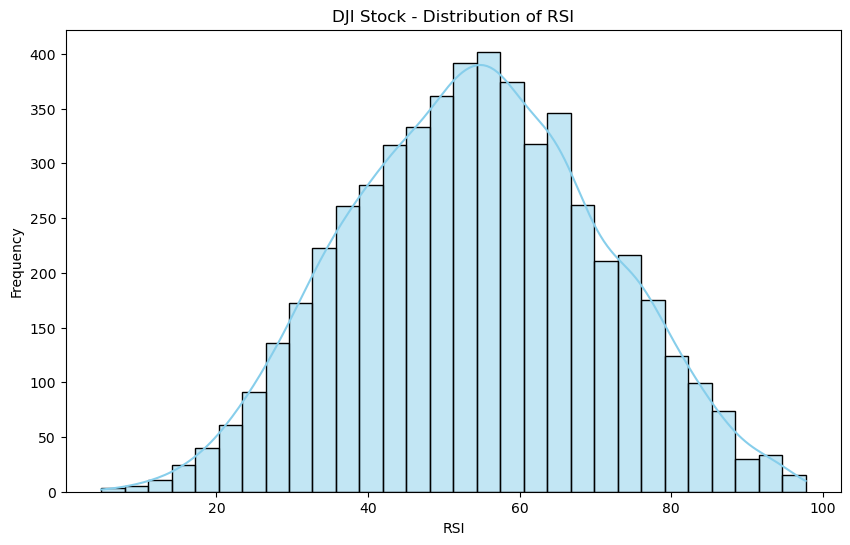

In [18]:
# Histogram of daily returns
plt.figure(figsize=(10, 6))
sns.histplot(data['RSI'].dropna(), bins=30, kde=True, color='skyblue')
plt.title(f'{symbol} Stock - Distribution of RSI')
plt.xlabel('RSI')
plt.ylabel('Frequency')
plt.show()


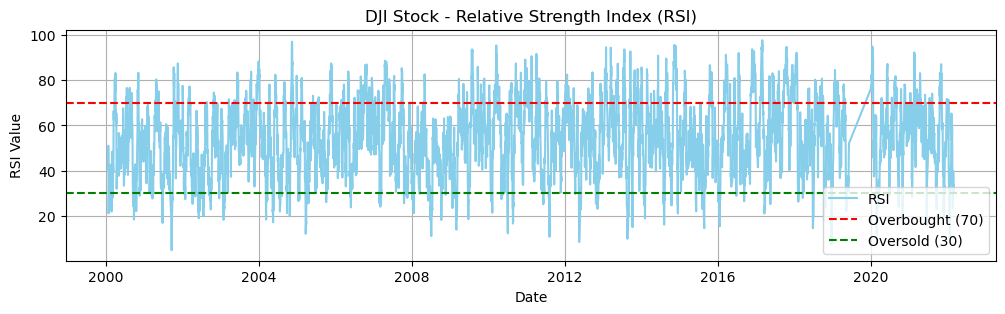

In [19]:
# Plotting RSI
plt.figure(figsize=(12, 3))
plt.plot(data['RSI'], label='RSI', color='skyblue')
plt.axhline(y=70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(y=30, color='green', linestyle='--', label='Oversold (30)')
plt.title(f'{symbol} Stock - Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI Value')
plt.legend()
plt.grid(True)
plt.show()

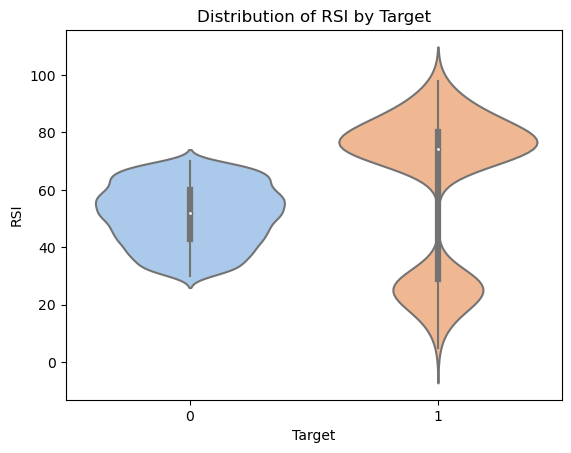

In [20]:
sns.violinplot(x='Target', y='RSI', data=data, palette='pastel', split=True)

# Additional formatting
plt.title('Distribution of RSI by Target')
plt.xlabel('Target')
plt.ylabel('RSI')
plt.show()

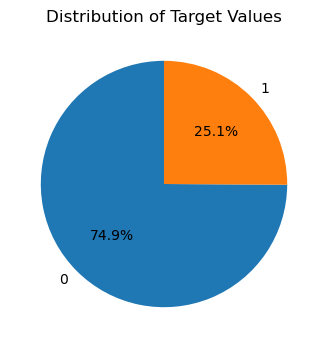

In [21]:
# Assuming 'Target' is a categorical variable in your dataset
target_counts = data['Target'].value_counts()

# Plotting a pie chart
plt.figure(figsize=(4, 4))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Target Values')
plt.show()

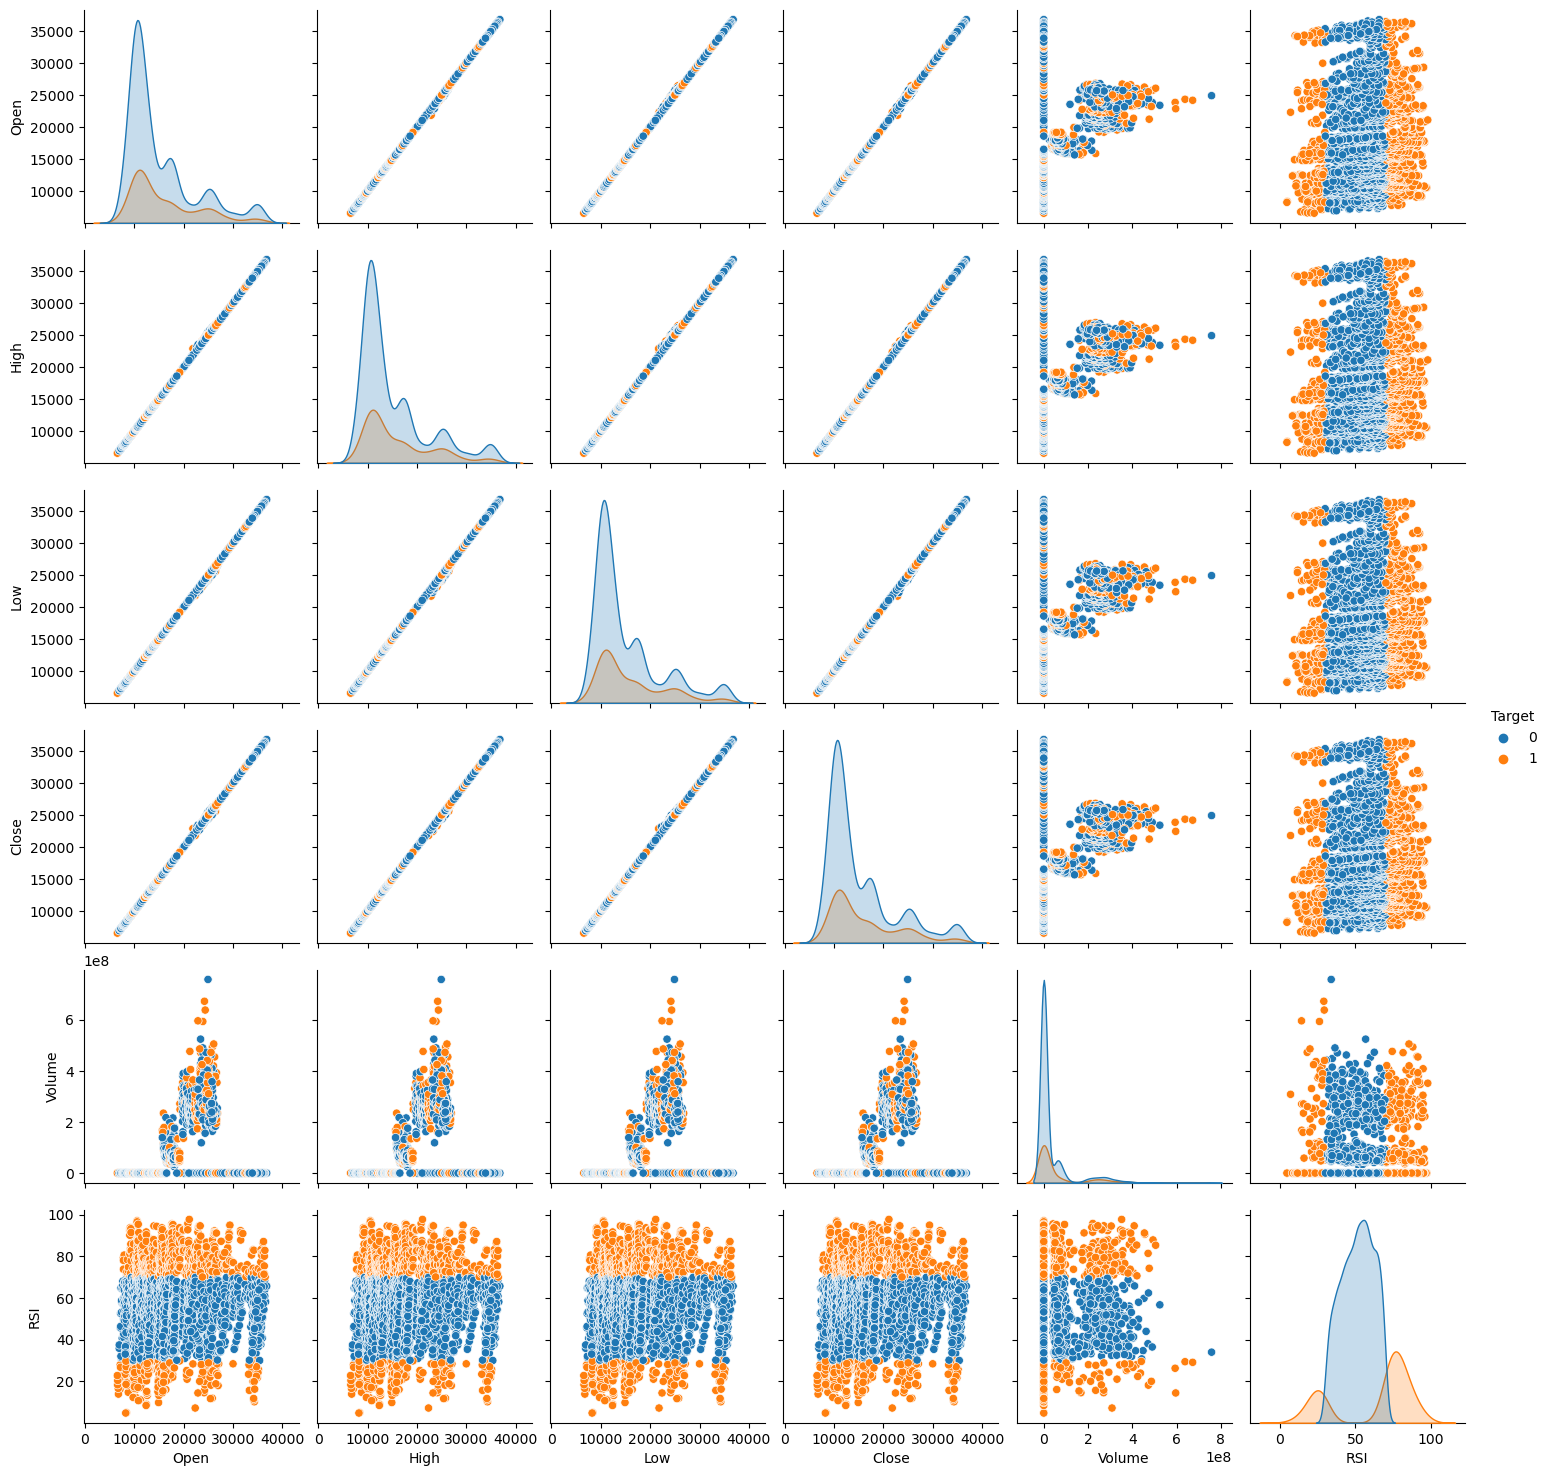

In [22]:
# Exploratory Data Analysis (EDA)
# Pairplot to visualize relationships between features
sns.pairplot(data[['Open', 'High', 'Low', 'Close', 'Volume','RSI', 'Target']], hue='Target')
plt.show()


## Train Test Split

In [23]:
X = data.drop('Target', axis=1)
y = data['Target']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

## Correlation

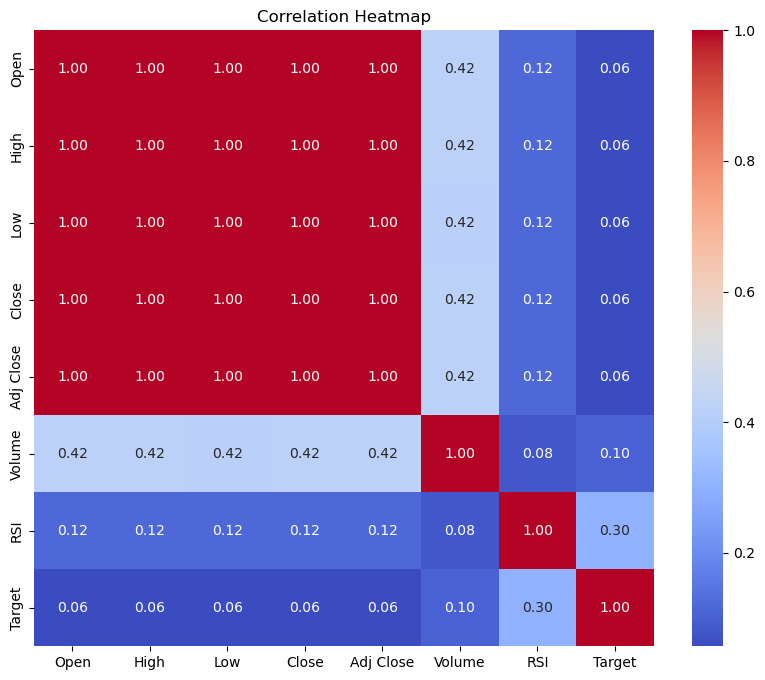

In [25]:
# Correlation heatmap
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [26]:
correlation_with_target = X_train.apply(lambda x: x.corr(y_train))

# Print the correlation with the target
print("Correlation with Target:")
print(correlation_with_target)

# Identify important features based on correlation with the target variable
important_features = correlation_with_target.abs().sort_values(ascending=False).index

# Print important features
print("\nImportant Features:")
print(important_features)

Correlation with Target:
Open         0.037977
High         0.038082
Low          0.037999
Close        0.038098
Adj Close    0.038098
Volume       0.085049
RSI          0.288301
dtype: float64

Important Features:
Index(['RSI', 'Volume', 'Close', 'Adj Close', 'High', 'Low', 'Open'], dtype='object')


## Data normalization

In [27]:
from sklearn.preprocessing import MinMaxScaler

In [28]:
# Step 1: Initialize MinMaxScaler
scaler = MinMaxScaler()

# Step 2: Fit and transform on training data
X_train_scaled = scaler.fit_transform(X_train)

# Step 3: Transform the test data using the parameters learned from the training data
X_test_scaled = scaler.transform(X_test)


/var/folders/tk/s_5s956j5ldbcsnzm9cvmz080000gn/T/ipykernel_96316/4278633473.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rsi_data_X_train, shade=True, color='skyblue', ax=axes[0])
/var/folders/tk/s_5s956j5ldbcsnzm9cvmz080000gn/T/ipykernel_96316/4278633473.py:18: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rsi_data_X_train_scaled, shade=True, color='skyblue', ax=axes[1])


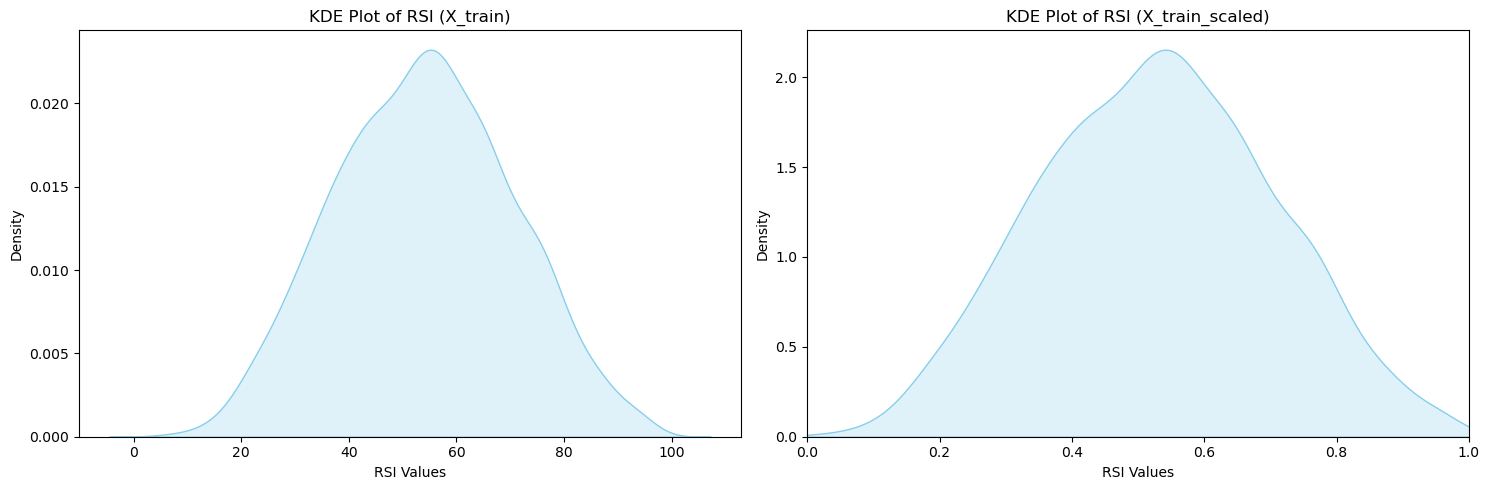

In [29]:
# Assuming 'X_train' is your DataFrame with 'RSI' column
rsi_data_X_train = X_train['RSI']

# Assuming 'X_train_scaled' is a NumPy array with the RSI data in the last column
rsi_data_X_train_scaled = X_train_scaled[:, -1]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot KDE for RSI from X_train
sns.kdeplot(rsi_data_X_train, shade=True, color='skyblue', ax=axes[0])
axes[0].set_title('KDE Plot of RSI (X_train)')
axes[0].set_xlabel('RSI Values')
axes[0].set_ylabel('Density')


# Plot KDE for RSI from X_train_scaled
sns.kdeplot(rsi_data_X_train_scaled, shade=True, color='skyblue', ax=axes[1])
axes[1].set_title('KDE Plot of RSI (X_train_scaled)')
axes[1].set_xlabel('RSI Values')
axes[1].set_ylabel('Density')
axes[1].set_xlim(0, 1)  # Set x-axis limits to the typical RSI range (0 to 1)

# Show the plots
plt.tight_layout()
plt.show()

### Functions to calculate Metrics for Classification Models

In [30]:
models_accuracy= {}
def Acc_cal(Model_name,y_test, y_pred):
    #from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report   
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=0)
    rec = recall_score(y_test, y_pred, pos_label=0)
    f1 = f1_score(y_test, y_pred, pos_label=0)

    arr = [[Model_name,acc,prec,rec,f1]]
    models_accuracy[Model_name]=acc
    df_ = pd.DataFrame(arr,columns=['Model','Accuracy','Precision','Recall','F1 Score'])
    df_
    return df_

In [31]:
def conf_mat(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    #plotting COnfusion Matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

## Model

### SVM

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
svm_classifier = SVC()

svm_classifier.fit(X_train_scaled, y_train)

predictions = svm_classifier.predict(X_test_scaled)


In [33]:
Acc_cal('svm_model',y_test, predictions)

Model  Accuracy  Precision    Recall  F1 Score
0  svm_model   0.97775   0.972778  0.998357  0.985401

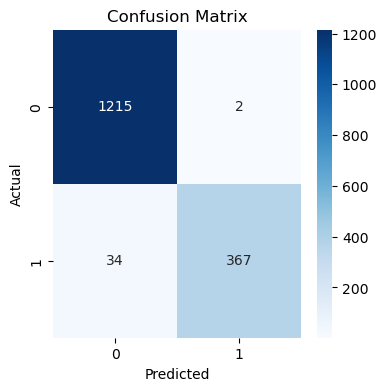

In [34]:
conf_mat(y_test, predictions)

### Logistic Regression 

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
# Create a Logistic Regression model
model = LogisticRegression(random_state=42)

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)


In [36]:
Acc_cal('Logistic Regression',y_test, y_pred)

Model  Accuracy  Precision  Recall  F1 Score
0  Logistic Regression  0.809023    0.79751     1.0   0.88735

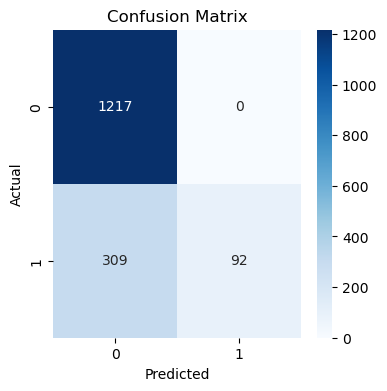

In [37]:
conf_mat(y_test, y_pred)

## Comparision of Accuracy

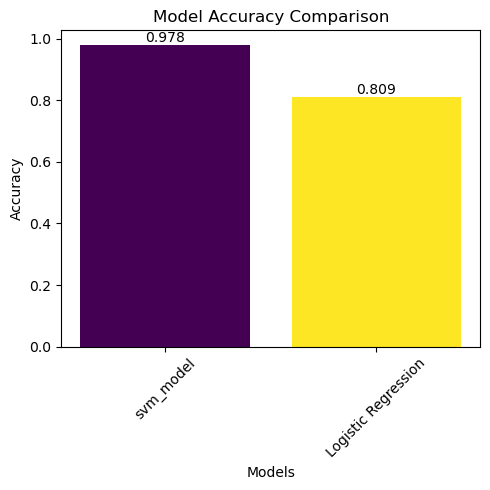

In [38]:
# Names of models
models = list(models_accuracy.keys())
# Corresponding accuracy values
accuracies = list(models_accuracy.values())

# Create a color list
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))

# Create bar plot with different colors for each bar
plt.figure(figsize=(5, 5))
bar_plot = plt.bar(models, accuracies, color=colors)

# Add title and labels
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')

# Adding value labels on top of each bar
for bar in bar_plot:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 3), ha='center', va='bottom')

# Display the plot with rotated model names for better readability
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the layout to fit everything neatly
plt.show()